In [ ]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from sklearn.metrics import pairwise_distances
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
import texthero
import gensim
!pip install texthero

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/yelp/filted_nv.csv')

## Train Test Split

In [ ]:
# interaction matrix
train_index = df[df.date < '2019-06-30'].index
train_df = df.loc[train_index]
users_items_matrix_df = train_df.pivot_table(index = 'user_id', columns = 'business_id', values = 'stars_r', aggfunc='mean')
users_items_matrix_df = users_items_matrix_df.fillna(0)

In [ ]:
test_index = df[df.date >= '2019-06-30'].index
test_df = df.loc[test_index][(df.loc[test_index].user_id.isin(train_df.user_id.unique())) & (df.loc[test_index].business_id.isin(train_df.business_id.unique()))]

In [ ]:
test_df.head()

,user_id,business_id,stars_r,date
17,NfU0zDaTMEQ4-X9dbQWd9A,bNpgu9sr3K18oLLw-eL75A,3,2019-08-28 20:56:00
22,NfU0zDaTMEQ4-X9dbQWd9A,Lq9rYrwvWV5QDBYzq7MGHQ,2,2019-08-28 21:21:55
28,NfU0zDaTMEQ4-X9dbQWd9A,-kbPPBNsIPDfMfgUGO7QhA,2,2019-09-03 20:57:55
46,SaSXRzjHx3SMTNnW90PetA,RESDUcs7fIiihp38-d6_6g,5,2019-12-03 22:43:34
76,OTGWjBCELxkZ6lpS2OEtxQ,nhp9uzhDN0rnMi5srVA3vw,5,2019-08-03 02:56:02


## Auto Encoder

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model


def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec) 
    # the output target is continus score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
# Build model
def train_model(users_items_matrix_df):
  X = users_items_matrix_df.values
  y = users_items_matrix_df.values

  model = autoEncoder(X)
  model.compile(optimizer = Adam(lr=0.0001), loss='mse')
  
  hist = model.fit(x=X, y=y,
                  epochs=10,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)
  retrun model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 4923)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               2521088   
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 4923)              2525499   
Total params: 5,309,499
Trainable params: 5,309,499
Non-trainable params: 0
___________________________________________________

In [ ]:
model = train_model(users_items_matrix_df)

Epoch 1/10
1300/1300 [==============================] - 70s 53ms/step - loss: 0.0221 - val_loss: 0.0083
Epoch 2/10
1300/1300 [==============================] - 64s 49ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 3/10
1300/1300 [==============================] - 64s 49ms/step - loss: 0.0083 - val_loss: 0.0078
Epoch 4/10
1300/1300 [==============================] - 63s 49ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 5/10
1300/1300 [==============================] - 63s 49ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 6/10
1300/1300 [==============================] - 64s 49ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 7/10
1300/1300 [==============================] - 63s 49ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 8/10
1300/1300 [==============================] - 62s 48ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 9/10
1300/1300 [==============================] - 65s 50ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 10/10
1300/1300 [==============================] - 67s 51m

In [ ]:
def predict_interaction_matrix(users_items_matrix_df,model):
  X = users_items_matrix_df.values
  new_matrix_chunk1 = model.predict(X[:10000]) * (X[:10000] == 0)
  new_matrix_chunk2 = model.predict(X[10000:20000]) * (X[10000:20000] == 0)
  new_matrix_chunk3 = model.predict(X[20000:30000]) * (X[20000:30000] == 0)
  new_matrix_chunk4 = model.predict(X[30000:40000]) * (X[30000:40000] == 0)
  new_matrix_chunk5 = model.predict(X[40000:50000]) * (X[40000:50000] == 0)
  new_matrix_chunk6 = model.predict(X[50000:60000]) * (X[50000:60000] == 0)
  new_matrix_chunk7 = model.predict(X[60000:70000]) * (X[60000:70000] == 0)
  new_matrix_chunk8 = model.predict(X[70000:80000]) * (X[70000:80000] == 0)
  new_matrix_chunk9 = model.predict(X[80000:]) * (X[80000:] == 0)
  new_matrix = np.vstack((new_matrix_chunk1, new_matrix_chunk2,
             new_matrix_chunk3, new_matrix_chunk4,
             new_matrix_chunk5, new_matrix_chunk6,
             new_matrix_chunk7, new_matrix_chunk8,
             new_matrix_chunk9))
  return new_matrix

In [ ]:
new_matrix = predict_interaction_matrix(users_items_matrix_df,model)
new_users_items_matrix_df  = pd.DataFrame(new_matrix, columns = users_items_matrix_df.columns, index = users_items_matrix_df.index)

## Collaborative Filtering - Rating

In [ ]:
new_users_items_matrix_df = users_items_matrix_df + new_users_items_matrix_df
test_user_matrix = new_users_items_matrix_df.loc[test_df.user_id.unique()]

In [ ]:
test_index = df[df.date >= '2019-06-30'].index
test_df = df.loc[test_index][(df.loc[test_index].user_id.isin(train_df.user_id.unique())) & (df.loc[test_index].business_id.isin(train_df.business_id.unique()))]

In [ ]:
user_similarity = pairwise_distances(test_user_matrix, new_users_items_matrix_df, metric='cosine')

In [ ]:
def generate_business_info(test_df, new_users_items_matrix_df):
  business_id_info = {}
  test_business_id = test_df.business_id.unique()
  for bus_id in test_business_id:
    current_business = new_users_items_matrix_df[bus_id]
    index = np.where(current_business>=1)[0]
    current_rating = current_business[index].values
    business_id_info[bus_id] = (index,current_rating)
  return business_id_info

def generate_user_id_index(test_user_matrix):
  test_user_id_index = {}
  for i in range(len(test_user_matrix.index)):
    test_user_id_index[test_user_matrix.index[i]] = i
  return test_user_id_index

def predict_rating_helpful_cf(test_df,business_id_info,user_similarity,test_user_id_index,helpful_threhold,num_sim):
  test_user_bus = test_df.to_dict('split')['data']
  test_ratings = []
  for i in test_user_bus:
    user_index = test_user_id_index[i[0]]
    current_sim = user_similarity[user_index][business_id_info[i[1]][0]]
    current_helpful = business_id_info[i[1]][2]
    selected_index = np.where(current_helpful>=helpful_threhold)[0]
    current_rating_list = business_id_info[i[1]][1]
    if selected_index.shape[0]>0:
      current_sim = current_sim[selected_index]
      current_rating = current_rating_list[selected_index]
    selected_index = np.argsort(current_sim)[:num_sim]
    current_sim = current_sim[selected_index]
    current_rating_list = current_rating_list[selected_index]
    current_rating = current_rating_list.mean()
    test_ratings.append(current_rating)
  return test_ratings

def predict_rating_cf(test_df,business_id_info,user_similarity,test_user_id_index,num_sim):
  test_user_bus = test_df.to_dict('split')['data']
  test_ratings = []
  for i in test_user_bus:
    user_index = test_user_id_index[i[0]]
    current_sim = user_similarity[user_index][business_id_info[i[1]][0]]
    selected_index = np.argsort(current_sim)[-num_sim:]
    current_sim = current_sim[selected_index]
    current_rating = (current_sim * business_id_info[i[1]][1][selected_index]).sum()/(current_sim).sum()
    test_ratings.append(current_rating)
  return test_ratings

In [ ]:
business_id_info = generate_business_info(test_df, new_users_items_matrix_df)
test_user_id_index = generate_user_id_index(test_user_matrix)

In [ ]:
test_no_dup = test_df.groupby(['user_id','business_id']).mean().reset_index()

In [ ]:
# baseline prediction
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_ratings = predict_rating_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,50)
test_no_dup['predict_rating_star'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star)))

R2: 0.10327442817629695
RMSE: 1.3953678373070193


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [ ]:
# prediction with useful threhold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
test_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,0.01,50)
test_no_dup['predict_rating_star_useful'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful)))

R2: 0.1245700494287193
RMSE: 1.378699542585866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# prediction with sentiment score
test_no_dup['predict_rating_overall'] = (test_no_dup.predict_rating_opinion+test_no_dup.predict_rating_star)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall)))

R2: 0.11546850068345405
RMSE: 1.3858718026279462


In [ ]:
# prediction with sentiment score and useful threhold
test_no_dup['predict_rating_overall_useful'] = (test_no_dup.predict_rating_opinion_useful+test_no_dup.predict_rating_star_useful)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful)))

R2: 0.13714706139529453
RMSE: 1.3687836160034232


## Sentiment analysis

In [ ]:
(df.stars_r.value_counts()/df.stars_r.count()).sort_index().cumsum()

1    0.126123
2    0.207031
3    0.319674
4    0.541496
5    1.000000
Name: stars_r, dtype: float64

In [ ]:
# preprocess
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x))
df['text'] = df['text'].apply(lambda x: re.sub(r'\s+', ' ',x))

In [ ]:
df['polarity_score'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['opinion_rating'] = pd.qcut(df['polarity_score'],[0,0.13,0.2,0.3,0.55,1],[1,2,3,4,5]).astype(int)

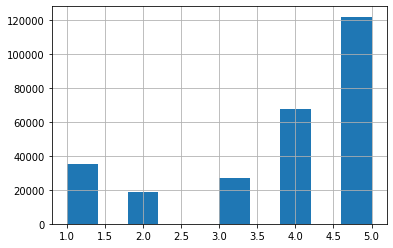

In [ ]:
df.opinion_rating.hist()

In [ ]:
np.corrcoef(df['stars_r'],df['opinion_rating'])

array([[1.        , 0.68230513],
       [0.68230513, 1.        ]])

In [ ]:
df['overal_rating'] = (df['stars_r']+df['opinion_rating'])/2

In [ ]:
# Predict with Opinion Score
users_items_matrix_df = train_df.pivot_table(index = 'user_id', columns = 'business_id', values = 'opinion_rating', aggfunc='mean')
users_items_matrix_df = users_items_matrix_df.fillna(0)
model = train_model(users_items_matrix_df)

In [ ]:
new_matrix = predict_interaction_matrix(X,model)

In [ ]:
new_users_items_matrix_df  = pd.DataFrame(new_matrix, columns = users_items_matrix_df.columns, index = users_items_matrix_df.index)
new_users_items_matrix_df = users_items_matrix_df + new_users_items_matrix_df
test_user_matrix = new_users_items_matrix_df.loc[test_df.user_id.unique()]

In [ ]:
user_similarity = pairwise_distances(test_user_matrix, new_users_items_matrix_df, metric='cosine')

In [ ]:
business_id_info = generate_business_info(test_df, new_users_items_matrix_df)
test_user_id_index = generate_user_id_index(test_user_matrix)

In [ ]:
test_no_dup = test_df.groupby(['user_id','business_id'])[['stars_r','opinion_rating','overal_rating']].mean().reset_index()
test_ratings = predict_rating_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


## LDA on Review

In [ ]:
stopwords = ['food','place','restaurant','like','good','great']
train_df['text'] = train_df['text'].str.lower()
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'[^A-Za-z]', ' ', x))
train_df['text'] = texthero.preprocessing.remove_stopwords(train_df['text'])
train_df['text'] = train_df['text'].apply(lambda x: re.sub(r'\s+', ' ',x))
train_df['text'] = train_df['text'].apply(lambda x: [i for i in x.split() if i not in stopwords])

In [ ]:
texts = list(train_df['text'].values)
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
num_topics = 12
lda_model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=id2word, passes=2, workers=4)

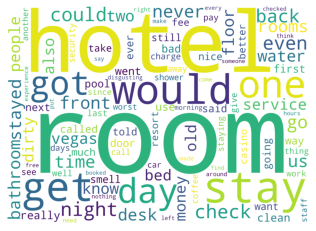

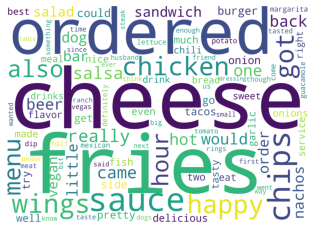

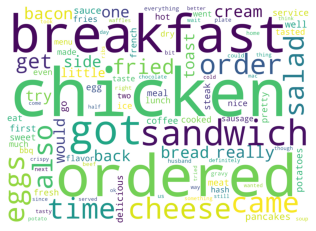

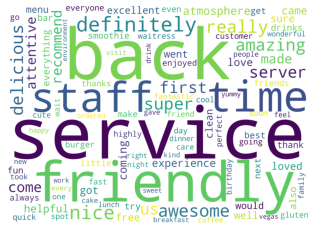

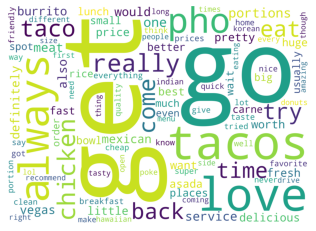

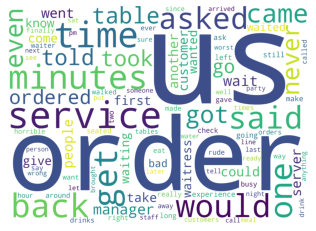

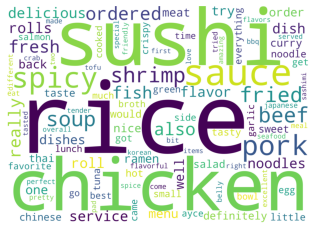

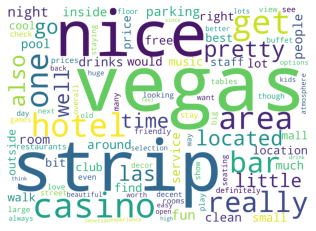

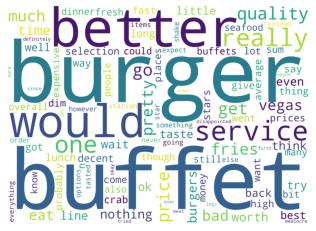

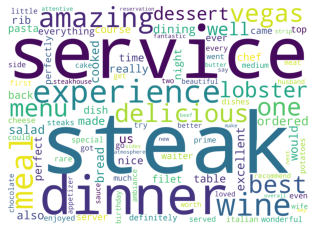

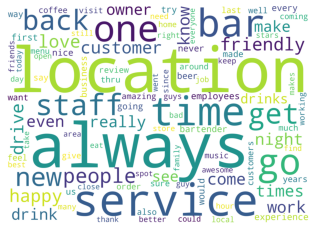

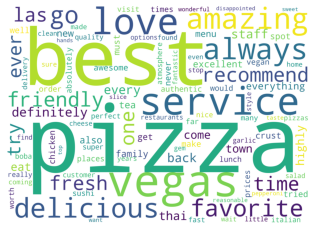

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
for i in range(12):
  topics = dict(lda_model.show_topic(i,topn=100))
  cloud = WordCloud(background_color='white',
            width=2500,
            height=1800,).generate_from_frequencies(topics)
  plt.imshow(cloud)
  plt.axis('off')
  plt.show()

In [ ]:
corpus_length = len(corpus)
lda_matrix = np.zeros((corpus_length,12))
for current_idx in range(corpus_length):
  topic_dis = lda_model.get_document_topics(corpus[current_idx])
  for topic in topic_dis:
    lda_matrix[current_idx,topic[0]] = topic[1]

In [ ]:
for i in range(12):
  train_df['LDA_'+str(i+1)] = lda_matrix[:,i]

In [ ]:
# encode LDA
df_business = df_reviews_train[['business_id','latitude', 'longitude']].drop_duplicates()
df_business = df_business.set_index('business_id')
features = ['stars_r', 'LDA_1', 'LDA_2', 'LDA_3', 'LDA_4', 'LDA_5', 'LDA_6', 'LDA_7', 'LDA_8',
       'LDA_9', 'LDA_10', 'LDA_11', 'LDA_12']
for feature in features:
  current_s = df_reviews_train.groupby('business_id').apply(lambda x: (x[feature]*x.useful_pred/x.useful_pred.sum()).sum())
  df_business[feature] = current_s

## Word2Vec and Cluster on Categories

In [ ]:
categories = df_all.categories.unique()

In [ ]:
categories_list = []
for cat in categories:
  cat = cat.replace('&',',')
  cat = cat.replace('/',',')
  current_cat = [i.strip() for i in cat.split(',')]
  categories_list.extend(current_cat)
  categories_list = list(set(categories_list))

In [ ]:
category_df = pd.DataFrame()
category_df['original_cat'] = categories_list
category_df['processed_cat'] = category_df['original_cat'].apply(lambda x: [i.strip() for i in re.sub('[^A-Za-z]', ' ',x).split()])

In [ ]:
def get_avg_vector(word_list):
  word_combined = '_'.join(word_list)
  if word_combined in total_words:
    total_array = w2v_model[word_combined]
  else:
    total_array = np.zeros(300)
    i = 0
    for word in word_list:
      if word in total_words:
        current_vec = w2v_model[word]
        total_array += current_vec
        i += 1
    if i > 0:
      total_array /= i
  return total_array

In [ ]:
import gensim.downloader as api
w2v_model = api.load('word2vec-google-news-300')

In [ ]:
total_words = w2v_model.vocab.keys()
zero_rows = np.where(avg_matrix.sum(axis=1)==0)[0]
avg_matrix = category_df['processed_cat'].apply(get_avg_vector)
avg_matrix = np.array([list(i) for i in avg_matrix.values])

In [ ]:
for NUM_CLUSTERS in range(50,51):
  kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25,avoid_empty_clusters=True)
  labels = kclusterer.cluster(avg_matrix, assign_clusters=True)
  silhouette_score = metrics.silhouette_score(avg_matrix, labels, metric='cosine')
  param_score[NUM_CLUSTERS] = silhouette_score
  print(NUM_CLUSTERS,':',silhouette_score)

In [ ]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer
from sklearn import metrics

kclusterer = KMeansClusterer(250, distance=nltk.cluster.util.cosine_distance, repeats=25,avoid_empty_clusters = True)
labels = kclusterer.cluster(avg_matrix, assign_clusters=True)
for i in zero_rows:
  labels.insert(i, None)

category_df['cluster'] = labels

In [ ]:
category_df['cluster'] = category_df['cluster'].rank(method='dense')
category_df['cluster'] = category_df['cluster'].astype(int)
category_dict = category_df.groupby('cluster').apply(lambda x: x.original_cat.tolist()).to_dict()

In [ ]:
def encode_category(x,i):
  category_list = category_dict[i]
  is_current_cat = 0
  for cat in category_list:
    if cat in x:
      is_current_cat = 1
      break
  return is_current_cat

In [ ]:
for i in category_dict.keys():
  df_business['cat_cluster_'+str(i)] = df_business['categories'].apply(lambda x: encode_category(x,i))

In [ ]:
df_business.drop('categories',axis=1,inplace=True)
df_business = df_business.set_index('business_id')

## Cluster Business

In [ ]:
import sklearn
scaler = sklearn.preprocessing.MinMaxScaler()
data = scaler.fit_transform(df_business)

In [ ]:
data.shape

(4923, 261)

#### K-means

In [ ]:
from sklearn.cluster import KMeans
cluster_metrics = {}
for NUM_CLUSTERS in range(10,100):
  kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(data)
  labels = kmeans.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 10 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

10 : 0.10047801154488736
20 : 0.13273720212709375
30 : 0.14515886576261844
40 : 0.14708346476958242
50 : 0.15822160225277104
60 : 0.1451666595935118
70 : 0.15764104790374148
80 : 0.16198608303479828
90 : 0.1675864143548813


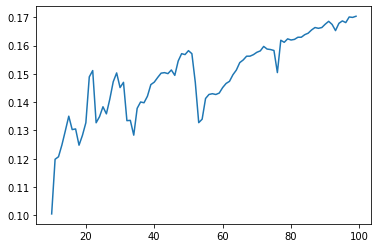

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
cluster_metrics = {}
for NUM_CLUSTERS in range(100,500,5):
  kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(data)
  labels = kmeans.labels_
  silhouette_score = sklearn.metrics.silhouette_score(data, labels)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 50 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

100 : 0.17082569534686726
150 : 0.16236210171055918
200 : 0.18599241793626198
250 : 0.19276074573967145
300 : 0.18400122582869965
350 : 0.18181676266701383
400 : 0.177372503995858
450 : 0.17327899109589442


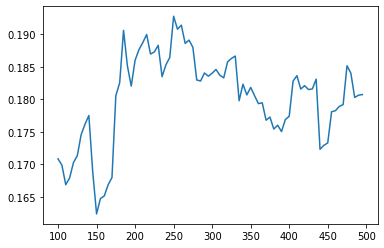

In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

#### GMM

In [ ]:
from sklearn.mixture import GaussianMixture
cluster_metrics = {}
for NUM_CLUSTERS in range(10,100,2):
  gm = GaussianMixture(n_components=NUM_CLUSTERS, random_state=0).fit(data)
  label = gm.predict(data)
  silhouette_score = sklearn.metrics.silhouette_score(data, label)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 10 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

10 : 0.06848311917193133
20 : 0.11752470883190344
30 : 0.12034936961479975
40 : 0.13024031791565527
50 : 0.1147819024565519
60 : 0.1505666781419422
70 : 0.15149361899348812
80 : 0.16775569138461985
90 : 0.17388026829160458


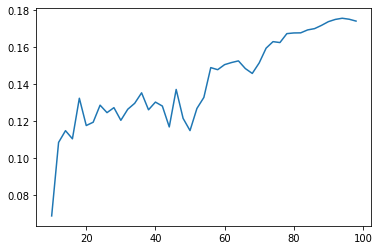

In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
cluster_metrics = {}
for NUM_CLUSTERS in range(100,500,5):
  gm = GaussianMixture(n_components=NUM_CLUSTERS, random_state=0).fit(data)
  label = gm.predict(data)
  silhouette_score = sklearn.metrics.silhouette_score(data, label)
  cluster_metrics[NUM_CLUSTERS] = silhouette_score
  if NUM_CLUSTERS % 10 == 0:
    print(NUM_CLUSTERS,':',silhouette_score)

100 : 0.16980775067240375
110 : 0.17633364185296377
120 : 0.18069290481793845
130 : 0.17689590043053727
140 : 0.18020669655615448
150 : 0.194273355962377
160 : 0.19662279925808332
170 : 0.17292826469269965
180 : 0.17507175871716707
190 : 0.1757545023880821
200 : 0.20153983715386306
210 : 0.1907350826608031
220 : 0.19687894417481994
230 : 0.19915401108063413
240 : 0.20049006286438265
250 : 0.19969866484892085
260 : 0.19953373599368374
270 : 0.20572819032025755
280 : 0.20766025201183863
290 : 0.20253295530768353
300 : 0.20040834695592477
310 : 0.19641078838665552
320 : 0.19787608512132118
330 : 0.19968938187232674
340 : 0.2001638513929962
350 : 0.1892296891475254
360 : 0.18996767185353372
370 : 0.18853438674402742
380 : 0.18992356332446458
390 : 0.19063625524540403
400 : 0.18157428372566473
410 : 0.17926665721344767
420 : 0.17698657759367328
430 : 0.17931554163601468


In [ ]:
plt.plot(list(cluster_metrics.keys()),list(cluster_metrics.values()))

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=280, random_state=0).fit(data)
label = gm.predict(data)

In [ ]:
probs = gm.predict_proba(data)

In [ ]:
df_business = df_business[['cluster_gmm']]
for i in range(probs.shape[1]):
  df_business['cluster_{}_prob'.format(str(i+1))] = probs[:,i]

## Predict Business With Cluster - GMM

In [ ]:
users_items_star_df = df_train.pivot_table(index = 'user_id', columns = 'cluster_gmm', values = 'stars_r', aggfunc='mean')
users_items_star_df = users_items_star_df.fillna(0)

In [ ]:
users_items_opinion_df = df_reviews_train.pivot_table(index = 'user_id', columns = 'cluster_gmm', values = 'opinion_rating', aggfunc='mean')
users_items_opinion_df = users_items_opinion_df.fillna(0)

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input, take the raw interaction matrix
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(150, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(75, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # L2 norm regularization term

    # Decoder
    # -----------------------------
    dec = Dense(150, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec) 
    # the output target is continus score, therefore the activation is linear
    #  regression {x-f(x)}
    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
# input
# input x
X = users_items_star_df.values
y = users_items_star_df.values

In [ ]:
# Build model
model = autoEncoder(X)
model.compile(optimizer = Adam(lr=0.0001), loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 280)]             0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 150)               42150     
_________________________________________________________________
LatentSpace (Dense)          (None, 75)                11325     
_________________________________________________________________
Dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 150)               11400     
_________________________________________________________________
UserScorePred (Dense)        (None, 280)               42280     
Total params: 107,155
Trainable params: 107,155
Non-trainable params: 0
_______________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
hist = model.fit(x=X, y=y,
                  epochs=10,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1, callbacks=[es])

In [ ]:
import tensorflow as tf
model_star = tf.keras.models.load_model('/content/drive/MyDrive/yelp/gmm/auto_encode_gmm_star')
model_opinion = tf.keras.models.load_model('/content/drive/MyDrive/yelp/gmm/auto_encode_gmm_opinion')

In [ ]:
def predict(model,users_items_df):
  X = users_items_df.values
  new_matrix = model.predict(X) * (X == 0)
  new_users_items_df = pd.DataFrame(new_matrix, columns = users_items_df.columns, index = users_items_df.index)
  new_users_items_df = new_users_items_df + users_items_df
  return new_users_items_df

In [ ]:
users_items_star_df = predict(model_star, users_items_star_df)
users_items_opinion_df = predict(model_opinion, users_items_opinion_df)

In [ ]:
def generate_user_id_index(test_user_matrix):
  test_user_id_index = {}
  for i in range(len(test_user_matrix.index)):
    test_user_id_index[test_user_matrix.index[i]] = i
  return test_user_id_index

In [ ]:
import pickle
with open("/content/drive/MyDrive/yelp/hierachic/business_id_info.pkl", "rb") as f:
  business_id_info_star = pickle.load(f)

with open("/content/drive/MyDrive/yelp/hierachic/business_id_info_opinion.pkl", "rb") as f:
  business_id_info_opinion = pickle.load(f)

In [ ]:
test_user_star_matrix = users_items_star_df.loc[test_df.user_id.unique()]
user_similarity_star = pairwise_distances(test_user_star_matrix, users_items_star_df, metric='cosine')

In [ ]:
test_user_opinion_matrix = users_items_opinion_df.loc[test_df.user_id.unique()]
user_similarity_opinion = pairwise_distances(test_user_opinion_matrix, users_items_opinion_df, metric='cosine')

In [ ]:
test_no_dup = test_df.groupby(['user_id','business_id']).mean().reset_index()

In [ ]:
user_similarity_star[0][np.where(user_similarity_star[0]<0.05)[0]]

array([4.4408921e-16])

In [ ]:
test_user_id_index_star = generate_user_id_index(test_user_star_matrix)
star_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info_star,user_similarity_star,test_user_id_index_star,0.01,50)
test_no_dup['predict_rating_star'] = star_ratings
test_user_id_index_opinion = generate_user_id_index(test_user_opinion_matrix)
opinion_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info_opinion,user_similarity_opinion,test_user_id_index_opinion,0.01,50)
test_no_dup['predict_rating_opinion'] = opinion_ratings
test_no_dup['predict_rating_overal'] = (test_no_dup['predict_rating_star']+test_no_dup['predict_rating_opinion'])/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overal))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overal)))

R2: 0.13720427716472705
RMSE: 1.3689382010098257


In [ ]:
# baseline prediction
test_user_id_index_star = generate_user_id_index(test_user_star_matrix)
test_ratings = predict_rating_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index_star,50)
test_no_dup['predict_rating_star'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star)))

R2: 0.08131666255288472
RMSE: 1.4125790823766866


In [ ]:
# prediction with useful threhold
test_ratings = predict_rating_helpful_cf(test_no_dup,business_id_info,user_similarity,test_user_id_index,0.01,50)
test_no_dup['predict_rating_star_useful'] = test_ratings
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_star_useful)))

R2: 0.12511321102337936
RMSE: 1.3784731446933458


In [ ]:
# prediction with sentiment score
test_no_dup['predict_rating_overall'] = (test_no_dup.predict_rating_opinion+test_no_dup.predict_rating_star)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall)))

R2: 0.09331409616701647
RMSE: 1.4033009274750692


In [ ]:
# prediction with sentiment score and useful threhold
test_no_dup['predict_rating_overall_useful'] = (test_no_dup.predict_rating_opinion_useful+test_no_dup.predict_rating_star_useful)/2
print('R2:',r2_score(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful))
print('RMSE:',np.sqrt(mean_squared_error(test_no_dup.dropna().stars_r,test_no_dup.dropna().predict_rating_overall_useful)))

R2: 0.13830739729574193
RMSE: 1.3680392654530553
